# 00. 개발 환경 설정

AI보안 HW3 - Adversarial Training 2021245139 이주현- 학습된 MNIST 이미지 분류 모델에 대한 Adversarial Training
- 재학습된 모델의 Adversarial Example에 대한 정확도에 따라 점수 부여 (단, FGSM을 사용하며 Epsilon은 0.1로 가정함)

## 00-0. 필요 라이브러리 설치

In [1]:
!pip3 install torch

## 00-1. 라이브러리 import
시각화, 데이터 처리, 모델 구축에 필요한 라이브러리들을 불러옵니다.

In [2]:


# matplotlib의 애니메이션 모듈로 애니메이션을 생성하는 데 사용됩니다.
import matplotlib.animation as animation
# 데이터 시각화와 플롯을 그리기 위한 Matplotlib 라이브러리
import matplotlib.pyplot as plt
# 수치 계산을 위한 NumPy 라이브러리
import numpy as np

# 진행 상황 표시를 위한 tqdm 라이브러리
from tqdm.auto import tqdm

# 운영 체제와 상호 작용을 위한 OS 라이브러리 (예: 파일 처리)
import os

# 신경망과 텐서 계산을 위한 PyTorch 라이브러리
import torch
import torch.nn as nn                 # 신경망 층 정의를 위한 모듈
import torch.optim as optim           # 최적화 알고리즘 모듈 (예: SGD, Adam)
import torch.nn.functional as F       # 다양한 신경망 함수 제공 (예: ReLU, softmax)

# 이미지 데이터 변환 및 데이터셋 로딩을 위한 라이브러리
import torchvision.transforms as transforms     # 이미지 데이터에 변환을 적용하는 모듈
import torchvision.datasets as datasets         # 데이터셋 로딩 모듈 (예: MNIST, CIFAR-10)
from torch.utils.data import DataLoader         # 데이터 배치 및 효율적 로딩을 위한 모듈
import torchvision.models as models             # 사전 학습된 모델 모듈 (예: ResNet, VGG)

# Matplotlib의 플로팅 모듈을 다시 불러옴 (중복되었지만 문제는 발생하지 않음)
import matplotlib.pyplot as plt
# NumPy도 다시 불러옴 (중복이지만 오류 없음)
import numpy as np


C:\Users\gyxo0\anaconda3\envs\torch_ev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 00-2. 학습 디바이스 정의
현재 사용 가능한 디바이스를 설정합니다.
'cuda' (GPU) 가 사용 가능한 경우 'cuda'를 선택하고, 그렇지 않으면 'cpu'를 선택합니다.
현재 선택된 디바이스를 출력합니다.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Now using {device}.")

Now using cuda.


# 01. 학습 준비

## 01-0. 구글 드라이브 마운트 및 
본인은 코랩이 아닌 환경을 구축함

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

#os.chdir('/content/drive/MyDrive/AI_Security/Adversarial Examples')

## 01-1. 데이터셋 로드 및 전처리
데이터에 대한 전처리 과정을 정의합니다.

In [5]:
    transform = transforms.Compose([
        transforms.ToTensor(), #이미지를 PyTorch 텐서로 변환합니다.
        transforms.Normalize((0.5,), (0.5,))  # 각 픽셀 값을 -1에서 1 사이의 값으로 정규화합니다.
    ])
    
    # MNIST 훈련 및 테스트 데이터셋을 다운로드 및 로드하며, transform을 적용하여 전처리합니다.
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    # DataLoader를 사용하여 데이터셋을 배치 단위로 불러옵니다.
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # 훈련 데이터는 배치 크기 64로 불러오고, 섞어서 제공
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # 테스트 데이터는 배치 크기 64로 불러오며, 섞지 않음ㅋ

## 01-02. 데이터셋 시각화

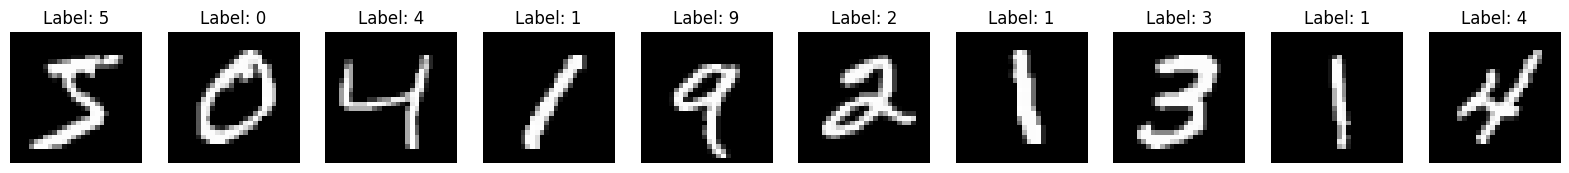

In [6]:
# 데이터셋에서 이미지를 불러와서 라벨과 함께 표시하는 함수 정의
def show_images_with_labels(dataset, num_images=10):
    # 1행 num_images열의 서브플롯을 생성하고, 크기를 20x20으로 설정
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    # num_images만큼 반복하여 이미지를 가져와서 플롯에 추가
    for i in range(num_images):
        image, label = dataset[i] # 데이터셋에서 이미지와 라벨을 가져옴
        axes[i].imshow(image.squeeze(), cmap='gray') # 이미지를 흑백(cmap='gray')으로 표시
        axes[i].set_title(f'Label: {label}') # 서브플롯 제목에 라벨을 표시
        axes[i].axis('off') # 축을 숨김
    plt.show()  # 플롯을 화면에 표시

# train_dataset에서 첫 10개의 이미지를 불러와서 show_images_with_labels 함수로 시각화
show_images_with_labels(train_dataset, num_images=10)

# 02. 모델 준비

## 02-01. 간단한 CNN


In [7]:
# CNN(Convolutional Neural Network) 모델 정의
class CNN(nn.Module):
    def __init__(self):
        # 부모 클래스(nn.Module)의 초기화 메서드 호출
        super(CNN, self).__init__()
        # 첫 번째 합성곱 층: 입력 채널 1개(흑백 이미지), 출력 채널 16개, 필터 크기 5x5, 패딩 2
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)   
        # 두 번째 합성곱 층: 입력 채널 16개, 출력 채널 32개, 필터 크기 5x5, 패딩 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)   
        # 풀링 층: 2x2 크기의 최대 풀링 필터를 적용, 풀링은 이미지 크기를 절반으로 줄임
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        # 첫 번째 완전 연결 층: 32 x 7 x 7 입력 크기, 128개의 출력 노드
        self.fc1 = nn.Linear(32 * 7 * 7, 128)   
        # 두 번째 완전 연결 층: 128개의 입력 노드, 10개의 출력 (MNIST 데이터셋 클래스 10개)
        self.fc2 = nn.Linear(128, 10)
        # ReLU 활성화 함수
        self.relu = nn.ReLU()

    # 순전파 정의
    def forward(self, x):
        # 첫 번째 합성곱 층 통과 후 활성화 함수와 풀링 적용
        x = self.pool(self.relu(self.conv1(x)))
        # 두 번째 합성곱 층 통과 후 활성화 함수와 풀링 적용
        x = self.pool(self.relu(self.conv2(x)))
        # 텐서를 1차원으로 펼침 (배치 크기 x 32*7*7)
        x = x.view(-1, 32 * 7 * 7)
        # 첫 번째 완전 연결 층 통과 후 ReLU 활성화 함수 적용
        x = self.relu(self.fc1(x))
        # 두 번째 완전 연결 층 통과하여 클래스 확률 값 출력
        x = self.fc2(x)
        return x


# 03. 모델 학습

## 03-01. 모델 학습 및 가중치 저장

In [8]:
# 모델을 저장할 디렉토리 설정
model_dir = './model'
os.makedirs(model_dir, exist_ok=True)   # 디렉토리가 없으면 생성

# CNN 모델 초기화 및 GPU로 전송
model = CNN()
model = model.cuda()  # GPU가 사용 가능한 경우 모델을 GPU에 할당

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()         # 다중 클래스 분류를 위한 교차 엔트로피 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)   # Adam 옵티마이저 사용, 학습률 0.001

# 학습 설정
num_epochs = 5   # 학습을 진행할 총 에포크 수

# 학습 루프 시작
for epoch in range(num_epochs):
    model.train()                    # 모델을 학습 모드로 전환
    running_loss = 0.0               # 에포크 내 손실을 추적할 변수 초기화

    # 배치 단위로 학습 데이터를 불러와 학습 진행
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.cuda(), labels.cuda()    # 이미지와 라벨을 GPU로 이동

        # 이전 배치의 gradients 초기화
        optimizer.zero_grad()

        # 순전파 -> 손실 계산 -> 역전파 -> 가중치 업데이트
        outputs = model(images)                    # 모델에 입력 데이터를 전달하여 예측값 계산
        loss = criterion(outputs, labels)          # 예측값과 실제 라벨 간 손실 계산
        loss.backward()                            # 손실에 대해 역전파 수행
        optimizer.step()                           # 옵티마이저로 가중치 갱신

        running_loss += loss.item()                # 손실을 누적

        # 100번째 배치마다 중간 손실과 학습률 출력
        if (i+1) % 100 == 0:
            current_lr = optimizer.param_groups[0]['lr']   # 현재 학습률 조회
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Loss: {running_loss/100:.4f}, Learning Rate: {current_lr}')
            running_loss = 0.0

# 학습 완료 후 모델 가중치 저장
model_path = os.path.join(model_dir, 'CNN_mnist.pth')
torch.save(model.state_dict(), model_path)  # 모델의 가중치만 저장


Epoch [1/5], Step [100/938], Loss: 0.7362, Learning Rate: 0.001
Epoch [1/5], Step [200/938], Loss: 0.1917, Learning Rate: 0.001
Epoch [1/5], Step [300/938], Loss: 0.1301, Learning Rate: 0.001
Epoch [1/5], Step [400/938], Loss: 0.1186, Learning Rate: 0.001
Epoch [1/5], Step [500/938], Loss: 0.0903, Learning Rate: 0.001
Epoch [1/5], Step [600/938], Loss: 0.0785, Learning Rate: 0.001
Epoch [1/5], Step [700/938], Loss: 0.0706, Learning Rate: 0.001
Epoch [1/5], Step [800/938], Loss: 0.0529, Learning Rate: 0.001
Epoch [1/5], Step [900/938], Loss: 0.0595, Learning Rate: 0.001
Epoch [2/5], Step [100/938], Loss: 0.0595, Learning Rate: 0.001
Epoch [2/5], Step [200/938], Loss: 0.0526, Learning Rate: 0.001
Epoch [2/5], Step [300/938], Loss: 0.0474, Learning Rate: 0.001
Epoch [2/5], Step [400/938], Loss: 0.0489, Learning Rate: 0.001
Epoch [2/5], Step [500/938], Loss: 0.0448, Learning Rate: 0.001
Epoch [2/5], Step [600/938], Loss: 0.0489, Learning Rate: 0.001
Epoch [2/5], Step [700/938], Loss: 0.042

# 04. 모델 검증

## 04-01.학습한 모델 Test


In [9]:
# 모델을 평가 모드로 전환
model.eval()

# 정확도 계산을 위한 변수 초기화
correct = 0   # 맞춘 예측의 개수
total = 0     # 전체 테스트 데이터 개수

# 평가 중에는 gradient 계산을 비활성화하여 메모리와 계산량 절약
with torch.no_grad():
    # 테스트 데이터셋에 대해 반복
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()  # 이미지와 라벨을 GPU로 전송
        # 모델에 입력 데이터를 전달하여 예측값 계산
        outputs = model(images)
        # 예측값 중 가장 높은 값을 가진 클래스 선택
        _, predicted = torch.max(outputs.data, 1)
        # 전체 라벨 개수 업데이트
        total += labels.size(0)
        # 맞춘 예측의 개수 업데이트
        correct += (predicted == labels).sum().item()

# 전체 테스트 데이터에 대한 정확도 출력
print(f'Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the model on the 10000 test images: 98.78%


##04-02. 모델의 Test 결과

Image 1:
Label: 7
Prediction: 7


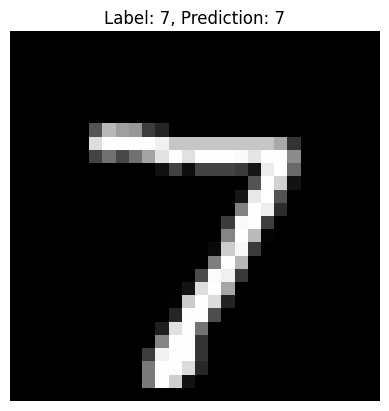

Image 2:
Label: 2
Prediction: 2


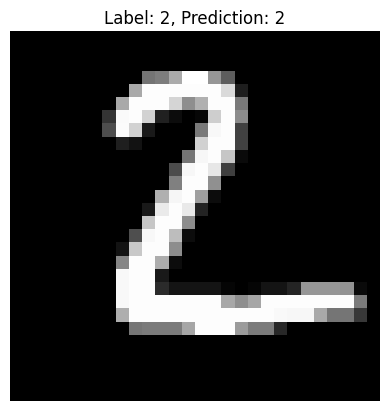

Image 3:
Label: 1
Prediction: 1


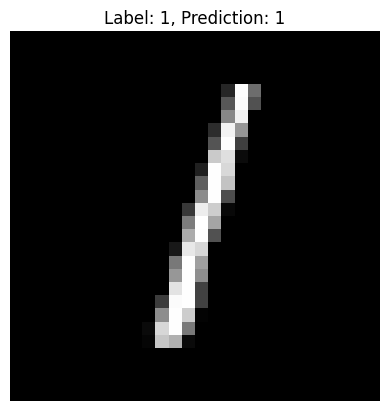

Image 4:
Label: 0
Prediction: 0


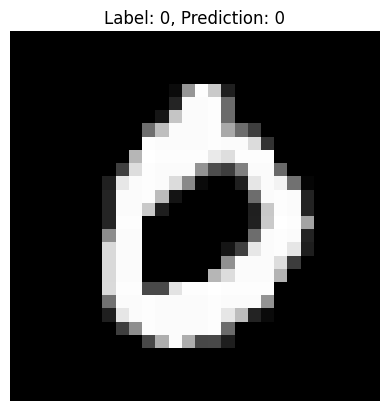

Image 5:
Label: 4
Prediction: 4


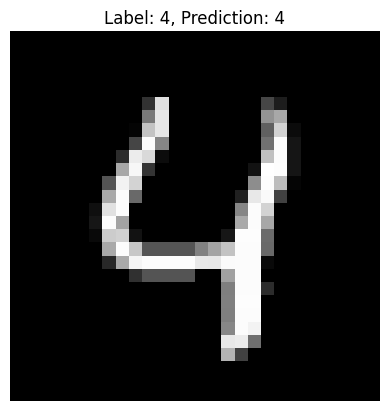

Image 6:
Label: 1
Prediction: 1


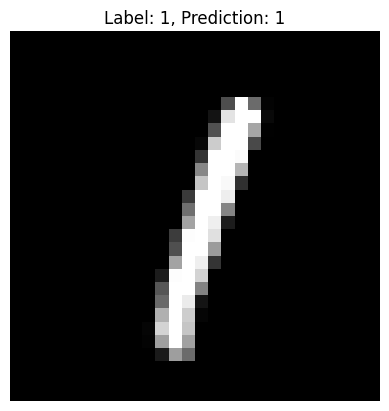

Image 7:
Label: 4
Prediction: 4


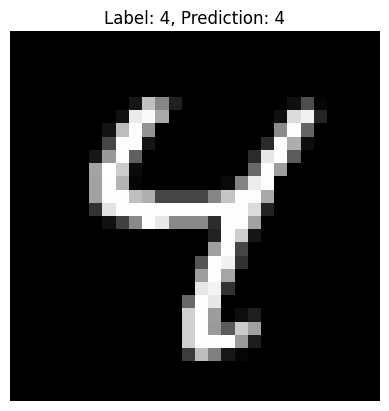

Image 8:
Label: 9
Prediction: 9


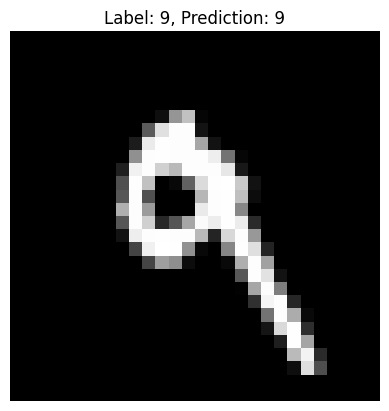

Image 9:
Label: 5
Prediction: 5


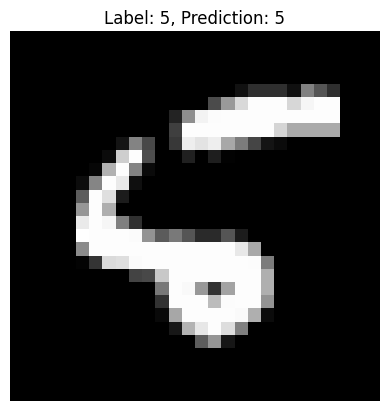

Image 10:
Label: 9
Prediction: 9


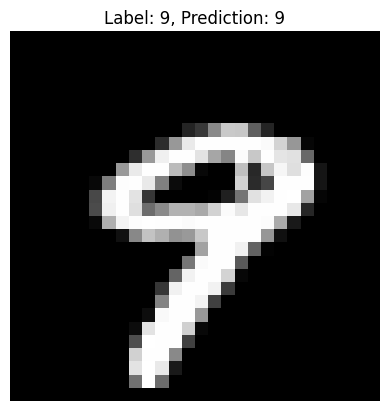

In [10]:
# 이미지 시각화를 위한 함수 정의
def imshow(img, title):
    # 이미지의 gradient 추적을 중단하고 CPU로 전송 후 numpy 배열로 변환
    img = img.detach().cpu().numpy().squeeze()
    plt.imshow(img, cmap='gray')  # 이미지 출력 (흑백)
    plt.title(title)  # 타이틀 설정
    plt.axis('off')  # 축 숨김
    plt.show()

# 테스트 이미지, 라벨, 예측 결과를 저장할 리스트 초기화
test_images = []
test_labels = []
test_predictions = []

# 테스트 데이터에서 예측을 수행
with torch.no_grad():  # 평가 시 gradient 계산 비활성화
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()  # 이미지와 라벨을 GPU로 이동
        outputs = model(images)  # 모델 예측 수행
        _, predicted = torch.max(outputs.data, 1)  # 예측값 중 확률이 가장 높은 클래스 선택

        # 10개의 이미지만 선택하여 리스트에 추가
        if len(test_images) < 10:
            test_images.append(images.cpu())  # 이미지 데이터를 CPU로 이동하여 리스트에 추가
            test_labels.append(labels.cpu())  # 실제 라벨을 CPU로 이동하여 리스트에 추가
            test_predictions.append(predicted.cpu())  # 예측값을 CPU로 이동하여 리스트에 추가

        if len(test_images) >= 10:
            break  # 10개 이상의 이미지가 모이면 반복 종료

# 리스트를 텐서로 변환하여 상위 10개만 사용
test_images = torch.cat(test_images)[:10]
test_labels = torch.cat(test_labels)[:10]
test_predictions = torch.cat(test_predictions)[:10]

# 10개의 이미지와 그에 대한 실제 라벨 및 예측 결과 출력
for i in range(10):
    print(f"Image {i+1}:")
    print(f"Label: {test_labels[i].item()}")        # 실제 라벨 출력
    print(f"Prediction: {test_predictions[i].item()}")  # 예측 결과 출력

    # 이미지 시각화, 타이틀에 실제 라벨과 예측 결과 표시
    imshow(test_images[i], title=f"Label: {test_labels[i].item()}, Prediction: {test_predictions[i].item()}")


# 05. FGSM 구현 및 결과


## 05-01. FGSM 공격

In [11]:
def fgsm_attack(image, epsilon, data_grad):
    # data_grad의 부호를 취하여 공격 방향을 결정
    sign_data_grad = data_grad.sign()
    # 원본 이미지에 perturbation을 추가하여 공격 이미지 생성
    perturbed_image = image + epsilon * sign_data_grad
    # perturbation을 추가한 후 값이 [0, 1] 범위로 유지되도록 클램핑
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

## 05-02. FGMS 공격 수행

In [12]:
# 학습한 CNN 모델의 가중치 로드
model_path = os.path.join(model_dir, 'CNN_mnist.pth')  # 모델 가중치 파일 경로
model.load_state_dict(torch.load(model_path, weights_only=True))  # 저장된 모델 가중치를 로드

# Test dataset 처음 10개 이미지 선택
data_iter = iter(test_loader)  # 테스트 데이터 로더에서 반복자 생성
images, labels = next(data_iter)  # 첫 번째 배치를 가져옴
images, labels = images[:10].cuda(), labels[:10].cuda()  # 첫 10개 이미지를 GPU로 전송
images.requires_grad = True  # 이미지 텐서에 대해 gradient 계산 활성화

# 원본 이미지 예측
outputs = model(images)  # 모델을 통해 예측값 계산
init_preds = outputs.max(1, keepdim=True)[1]  # 예측값 중 가장 높은 확률을 가진 클래스를 선택

# 손실 계산 (CrossEntropyLoss)
loss = nn.CrossEntropyLoss()(outputs, labels)  # 예측값과 실제 레이블 사이의 CrossEntropy 손실 계산
model.zero_grad()  # 모델의 gradient를 초기화
# 역전파 수행하여 입력 이미지에 대한 gradient 계산
loss.backward()

# FGSM 공격 수행
data_grads = images.grad.data  # 이미지에 대한 gradient 추출
epsilon = 0.7  # 공격 강도 설정 (epsilon 값: 0.1, 0.3, 0.5, 0.7 등)
perturbed_images = fgsm_attack(images, epsilon, data_grads)  # FGSM 공격을 통해 공격 이미지 생성

# 공격 이미지 예측
outputs = model(perturbed_images)  # 공격된 이미지를 모델에 입력하여 예측 수행
final_preds = outputs.max(1, keepdim=True)[1]  # 공격 이미지에 대한 예측값 중 가장 높은 클래스를 선택


In [13]:
# 적대적 예제에 대한 정확도 계산 및 출력
adversarial_accuracy = 100 * correct / total
print(f'Accuracy on adversarial examples: {adversarial_accuracy:.2f}%')

Accuracy on adversarial examples: 98.78%


## 05-03. 공격 수행 시각화


Image 1:
Original Label: 7
Initial Prediction: 7
Final Prediction: 3 


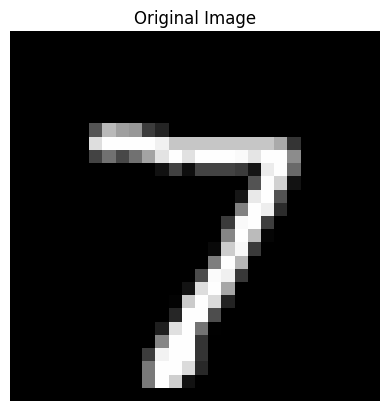

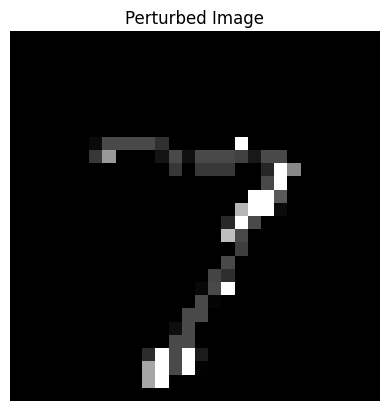

Image 2:
Original Label: 2
Initial Prediction: 2
Final Prediction: 2 (Attack failed)


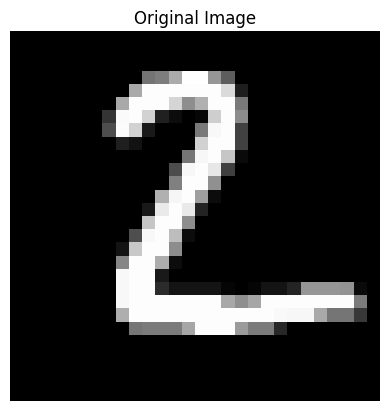

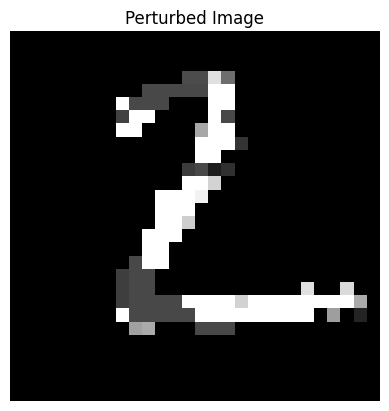

Image 3:
Original Label: 1
Initial Prediction: 1
Final Prediction: 8 


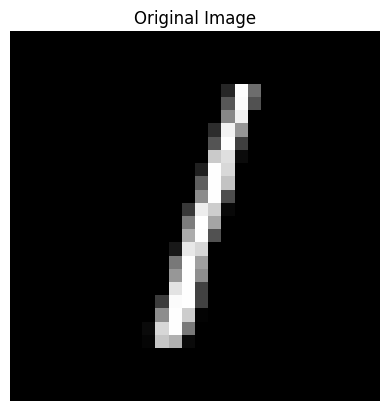

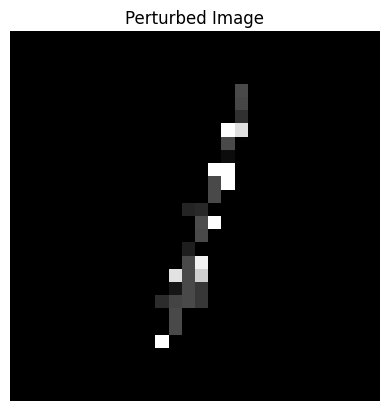

Image 4:
Original Label: 0
Initial Prediction: 0
Final Prediction: 6 


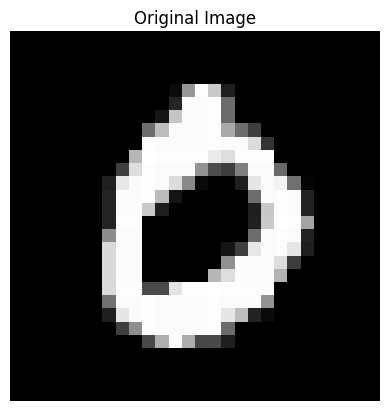

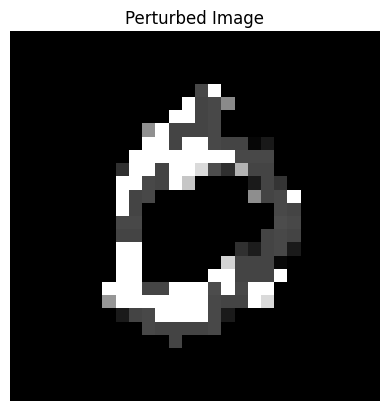

Image 5:
Original Label: 4
Initial Prediction: 4
Final Prediction: 9 


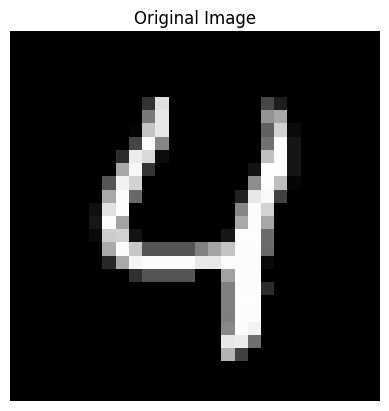

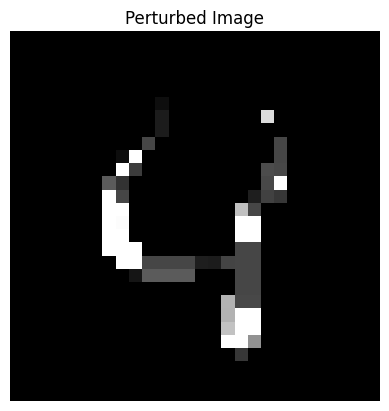

Image 6:
Original Label: 1
Initial Prediction: 1
Final Prediction: 5 


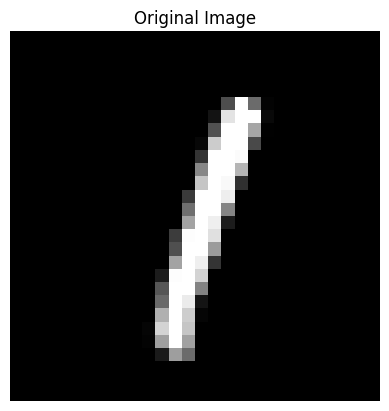

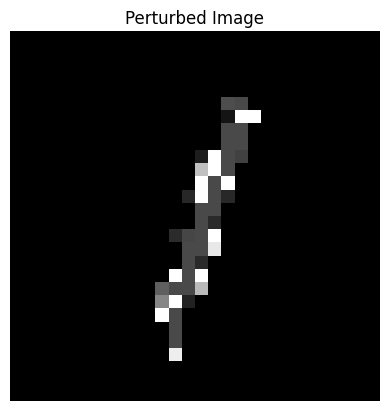

Image 7:
Original Label: 4
Initial Prediction: 4
Final Prediction: 8 


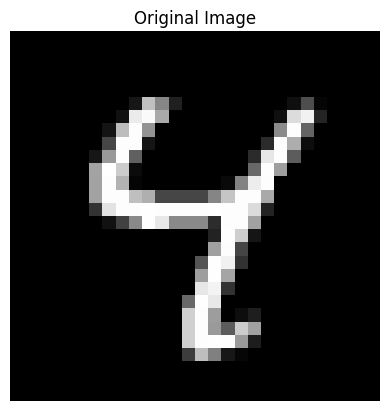

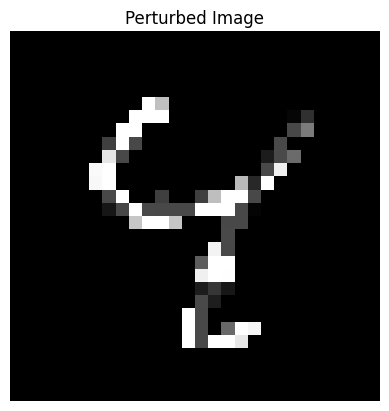

Image 8:
Original Label: 9
Initial Prediction: 9
Final Prediction: 4 


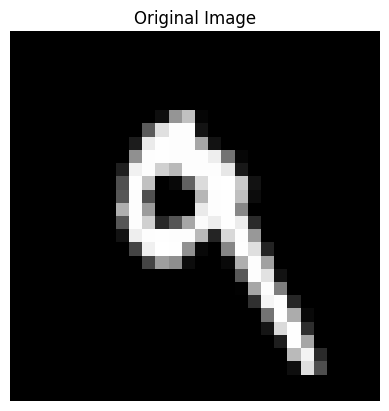

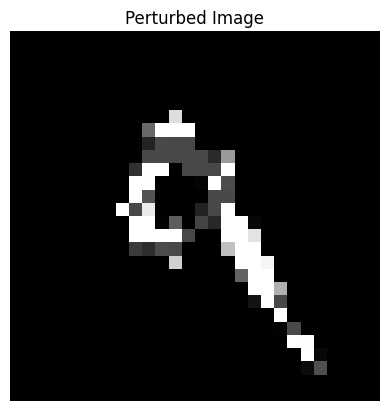

Image 9:
Original Label: 5
Initial Prediction: 5
Final Prediction: 6 


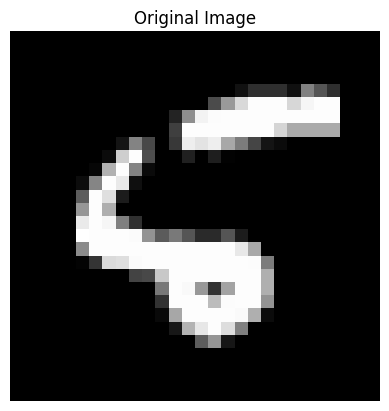

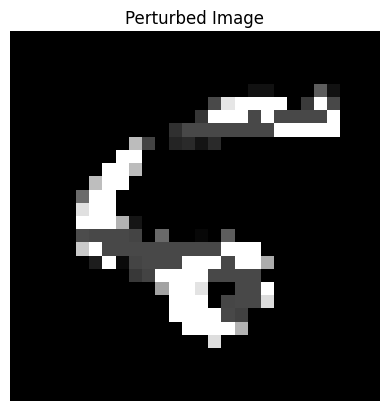

Image 10:
Original Label: 9
Initial Prediction: 9
Final Prediction: 8 


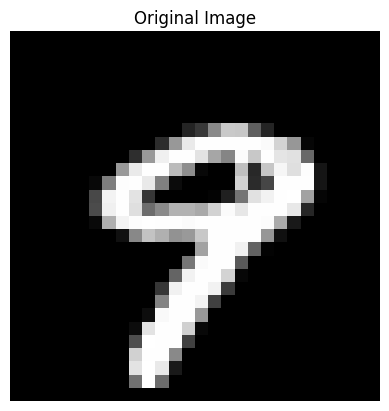

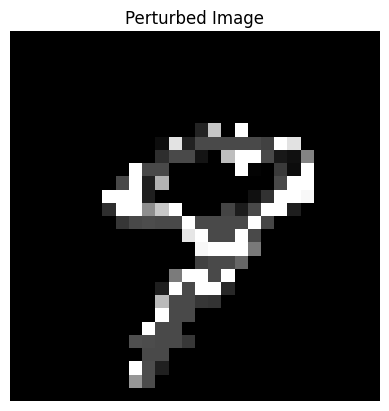

In [14]:
# 이미지 시각화를 위한 함수
def imshow(img, title):
    img = img.detach().cpu().numpy().squeeze()  # gradient 추적을 중지하고, numpy 배열로 변환하여 시각화
    plt.imshow(img, cmap='gray')  # 이미지 출력, cmap='gray'는 흑백 이미지로 표시
    plt.title(title)  # 타이틀 설정
    plt.axis('off')  # 축 숨김
    plt.show()  # 이미지 표시

# 결과 출력 및 시각화
for i in range(10):
    print(f"Image {i+1}:")
    print(f"Original Label: {labels[i].item()}")  # 원본 레이블 출력
    print(f"Initial Prediction: {init_preds[i].item()}")  # 초기 예측 출력 (공격 전 예측)
    print(f"Final Prediction: {final_preds[i].item()} {'(Attack failed)' if final_preds[i].item() == labels[i].item() else ''}")  # 공격 후 예측 출력, 공격이 실패한 경우 '(Attack failed)' 표시

    # 원본 이미지 시각화
    imshow(images[i], title="Original Image")  # 원본 이미지를 시각화

    # 공격 이미지 시각화
    imshow(perturbed_images[i], title="Perturbed Image")  # FGSM 공격이 적용된 이미지를 시각화


In [15]:
# Load the pretrained model
# 모델 가중치만 로드
model.load_state_dict(torch.load(os.path.join(model_dir, 'CNN_mnist.pth'), weights_only=True), strict=False)
model.eval()  # 모델을 평가 모드로 설정

correct, total = 0, 0  # 정확도 계산을 위한 변수
epsilon = 0.1  # FGSM 공격 강도

# 전체 테스트 세트에 대한 평가
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)  # 데이터를 디바이스(CPU/GPU)로 이동
    images.requires_grad = True  # FGSM 공격을 위해 입력 이미지에 대한 gradient 계산 활성화

    # 초기 예측
    outputs = model(images)  # 모델의 출력 계산
    _, init_preds = outputs.max(1)  # 최대 값의 인덱스를 가져와 초기 예측을 계산

    # 손실 및 gradient 계산
    loss = F.cross_entropy(outputs, labels)  # 손실 계산 (교차 엔트로피)
    model.zero_grad()  # 기존 gradient 초기화
    loss.backward()  # 역전파를 통해 gradient 계산
    data_grad = images.grad.data  # 이미지에 대한 gradient 저장

    # 적대적 예제 생성
    perturbed_images = fgsm_attack(images, epsilon, data_grad)  # FGSM을 사용하여 공격 예제 생성

    # 적대적 예제에 대한 예측 평가
    outputs_adv = model(perturbed_images)  # 공격 이미지에 대한 예측
    _, final_preds = outputs_adv.max(1)  # 공격 이미지를 기준으로 최종 예측을 계산
    total += labels.size(0)  # 총 이미지 수
    correct += (final_preds == labels).sum().item()  # 정확도 계산 (예측과 실제 레이블이 일치하는 경우의 수)


In [16]:
# 적대적 예제에 대한 정확도 계산 및 출력
adversarial_accuracy = 100 * correct / total
print(f'Accuracy on adversarial examples: {adversarial_accuracy:.2f}%')

Accuracy on adversarial examples: 94.08%


Image 1:
Original Label: 1
Initial Prediction: 1
Final Prediction: 1 (Attack failed)


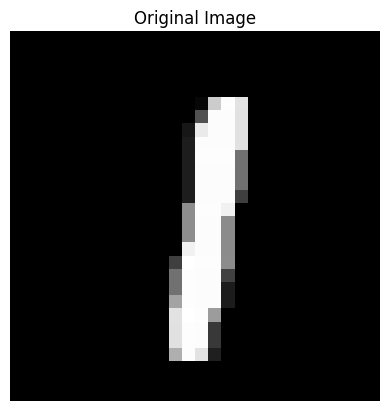

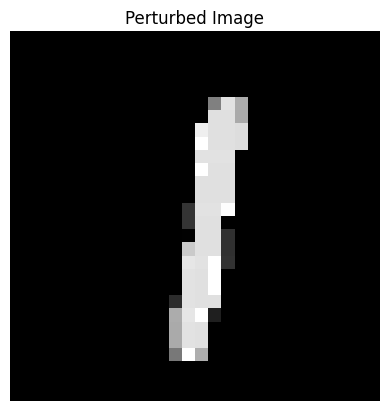

Image 2:
Original Label: 2
Initial Prediction: 2
Final Prediction: 2 (Attack failed)


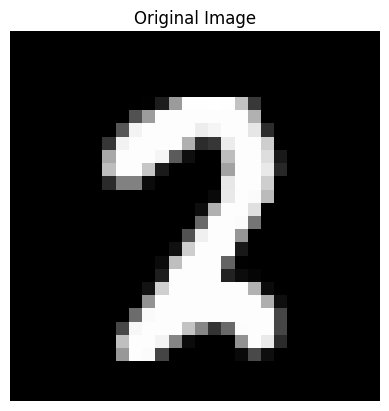

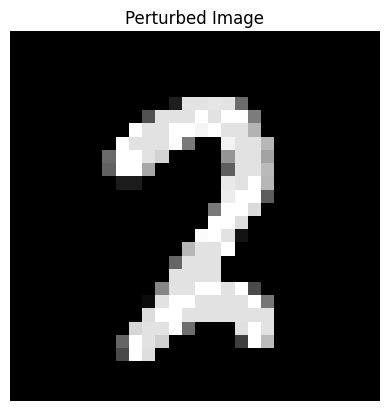

Image 3:
Original Label: 3
Initial Prediction: 3
Final Prediction: 3 (Attack failed)


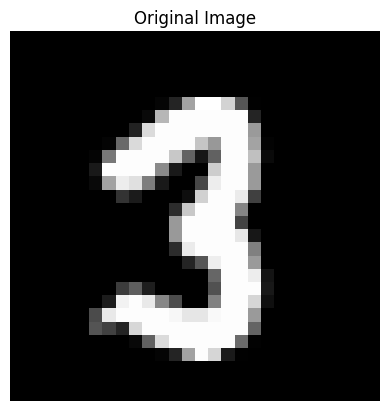

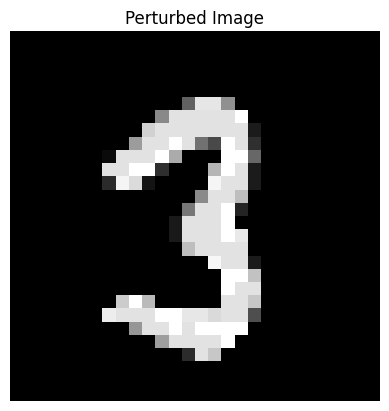

Image 4:
Original Label: 4
Initial Prediction: 4
Final Prediction: 4 (Attack failed)


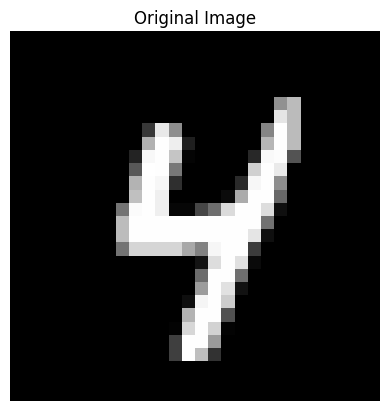

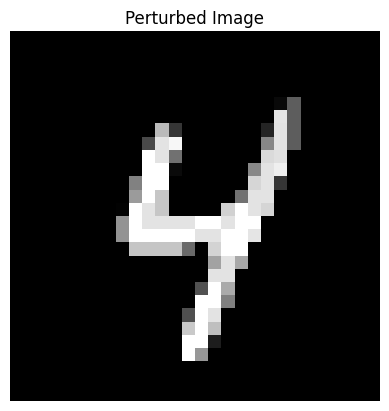

Image 5:
Original Label: 5
Initial Prediction: 5
Final Prediction: 5 (Attack failed)


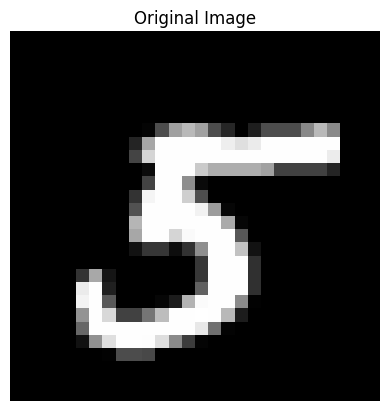

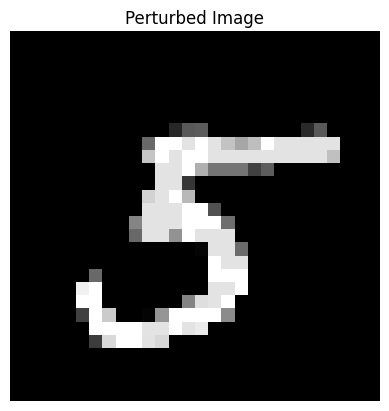

Image 6:
Original Label: 6
Initial Prediction: 6
Final Prediction: 6 (Attack failed)


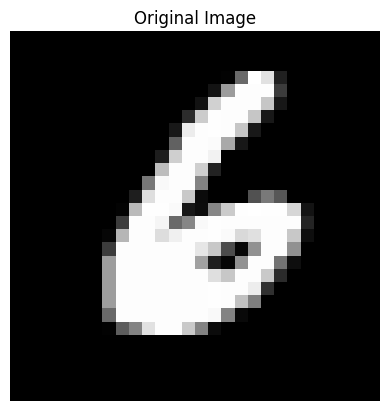

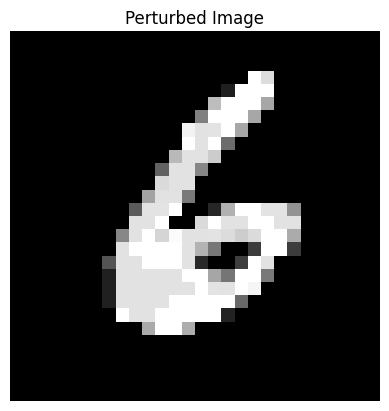

Image 7:
Original Label: 7
Initial Prediction: 7
Final Prediction: 7 (Attack failed)


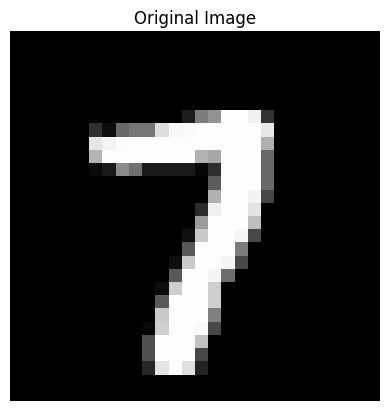

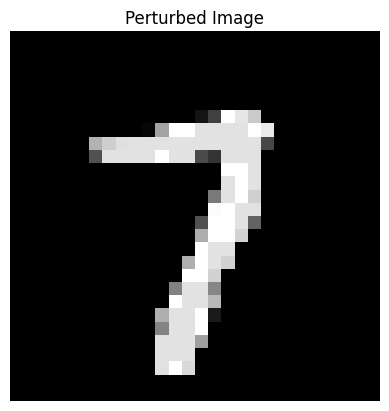

Image 8:
Original Label: 8
Initial Prediction: 8
Final Prediction: 8 (Attack failed)


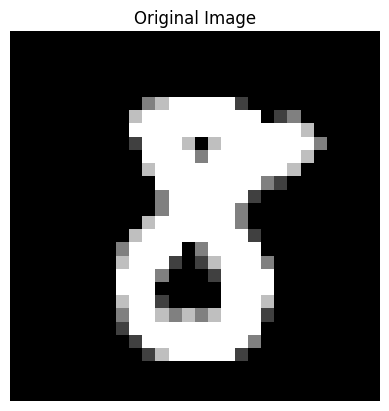

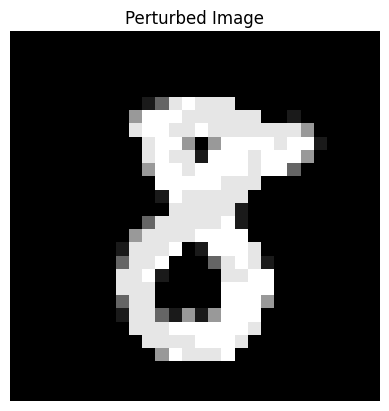

Image 9:
Original Label: 9
Initial Prediction: 9
Final Prediction: 9 (Attack failed)


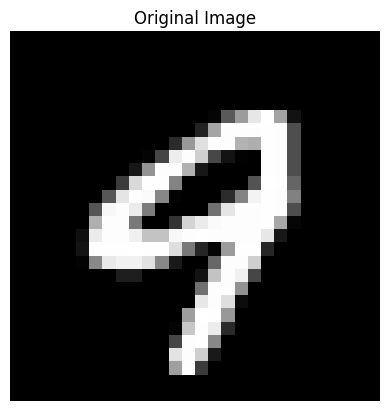

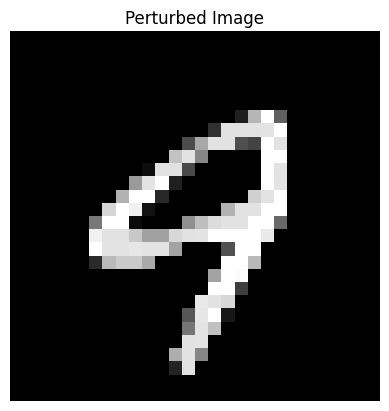

Image 10:
Original Label: 0
Initial Prediction: 0
Final Prediction: 0 (Attack failed)


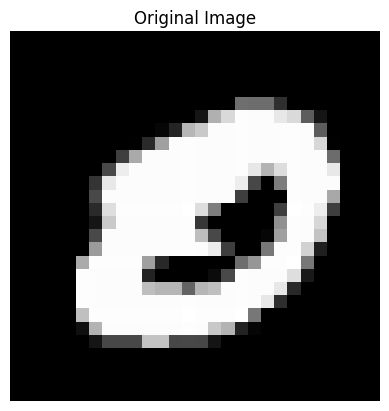

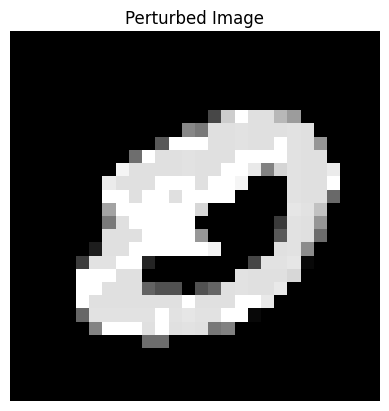

In [17]:
# 이미지 시각화를 위한 함수
def imshow(img, title):
    img = img.detach().cpu().numpy().squeeze()  # gradient 추적을 중지하고, numpy 배열로 변환하여 시각화
    plt.imshow(img, cmap='gray')  # 이미지 출력, cmap='gray'는 흑백 이미지로 표시
    plt.title(title)  # 타이틀 설정
    plt.axis('off')  # 축 숨김
    plt.show()  # 이미지 표시

# 결과 출력 및 시각화
for i in range(10):
    print(f"Image {i+1}:")
    print(f"Original Label: {labels[i].item()}")  # 원본 레이블 출력
    print(f"Initial Prediction: {init_preds[i].item()}")  # 초기 예측 출력 (공격 전 예측)
    print(f"Final Prediction: {final_preds[i].item()} {'(Attack failed)' if final_preds[i].item() == labels[i].item() else ''}")  # 공격 후 예측 출력, 공격이 실패한 경우 '(Attack failed)' 표시

    # 원본 이미지 시각화
    imshow(images[i], title="Original Image")  # 원본 이미지를 시각화

    # 공격 이미지 시각화
    imshow(perturbed_images[i], title="Perturbed Image")  # FGSM 공격이 적용된 이미지를 시각화
